# Web Attack Payload Detect Model
This model is designed to detect web attack payloads in incoming web requests. It analyzes the content of the requests to identify patterns and signatures commonly associated with web attacks, such as SQL injection, cross-site scripting (XSS), and other malicious activities.

## Import Libraries


In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import OrdinalEncoder
from keras.optimizers import Adam
from sklearn.utils import shuffle
from keras.layers import Dense, SimpleRNN
from keras.layers import Dense, Conv1D, GlobalMaxPooling1D
import tensorflow as tf
import torch
import torch.nn as nn



## Data Collection

In [130]:
df = pd.read_csv('csic_database.csv', on_bad_lines='skip')
df1 = df

In [131]:
df.head()

,Unnamed: 0,Method,User-Agent,Pragma,Cache-Control,Accept,Accept-encoding,Accept-charset,language,host,cookie,content-type,connection,lenght,content,classification,URL
0,Normal,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=1F767F17239C9B670A39E9B10C3825F4,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/index.jsp HTTP/1.1
1,Normal,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=81761ACA043B0E6014CA42A4BCD06AB5,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/publico/anadir.j...
2,Normal,POST,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=933185092E0B668B90676E0A2B0767AF,application/x-www-form-urlencoded,Connection: close,Content-Length: 68,id=3&nombre=Vino+Rioja&precio=100&cantidad=55&...,0,http://localhost:8080/tienda1/publico/anadir.j...
3,Normal,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=8FA18BA82C5336D03D3A8AFA3E68CBB0,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/publico/autentic...
4,Normal,POST,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=7104E6C68A6BCF1423DAE990CE49FEE2,application/x-www-form-urlencoded,Connection: close,Content-Length: 63,modo=entrar&login=choong&pwd=d1se3ci%F3n&remem...,0,http://localhost:8080/tienda1/publico/autentic...


## Data inspection

In [132]:
df.shape

(61065, 17)

In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61065 entries, 0 to 61064
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       61065 non-null  object
 1   Method           61065 non-null  object
 2   User-Agent       61065 non-null  object
 3   Pragma           61065 non-null  object
 4   Cache-Control    61065 non-null  object
 5   Accept           60668 non-null  object
 6   Accept-encoding  61065 non-null  object
 7   Accept-charset   61065 non-null  object
 8   language         61065 non-null  object
 9   host             61065 non-null  object
 10  cookie           61065 non-null  object
 11  content-type     17977 non-null  object
 12  connection       61065 non-null  object
 13  lenght           17977 non-null  object
 14  content          17977 non-null  object
 15  classification   61065 non-null  int64 
 16  URL              61065 non-null  object
dtypes: int64(1), object(16)
memory 

In [134]:
df.rename(columns={'Unnamed: 0': 'Class'}, inplace=True)

In [135]:
df.head()

,Class,Method,User-Agent,Pragma,Cache-Control,Accept,Accept-encoding,Accept-charset,language,host,cookie,content-type,connection,lenght,content,classification,URL
0,Normal,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=1F767F17239C9B670A39E9B10C3825F4,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/index.jsp HTTP/1.1
1,Normal,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=81761ACA043B0E6014CA42A4BCD06AB5,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/publico/anadir.j...
2,Normal,POST,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=933185092E0B668B90676E0A2B0767AF,application/x-www-form-urlencoded,Connection: close,Content-Length: 68,id=3&nombre=Vino+Rioja&precio=100&cantidad=55&...,0,http://localhost:8080/tienda1/publico/anadir.j...
3,Normal,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=8FA18BA82C5336D03D3A8AFA3E68CBB0,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/publico/autentic...
4,Normal,POST,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=7104E6C68A6BCF1423DAE990CE49FEE2,application/x-www-form-urlencoded,Connection: close,Content-Length: 63,modo=entrar&login=choong&pwd=d1se3ci%F3n&remem...,0,http://localhost:8080/tienda1/publico/autentic...


In [136]:
lb  = tuple(df['Class'])
anomaly  = 0
normal = 0
for x in lb:
   if(x=='Normal'):
     normal+=1
anomaly = len(lb)-normal

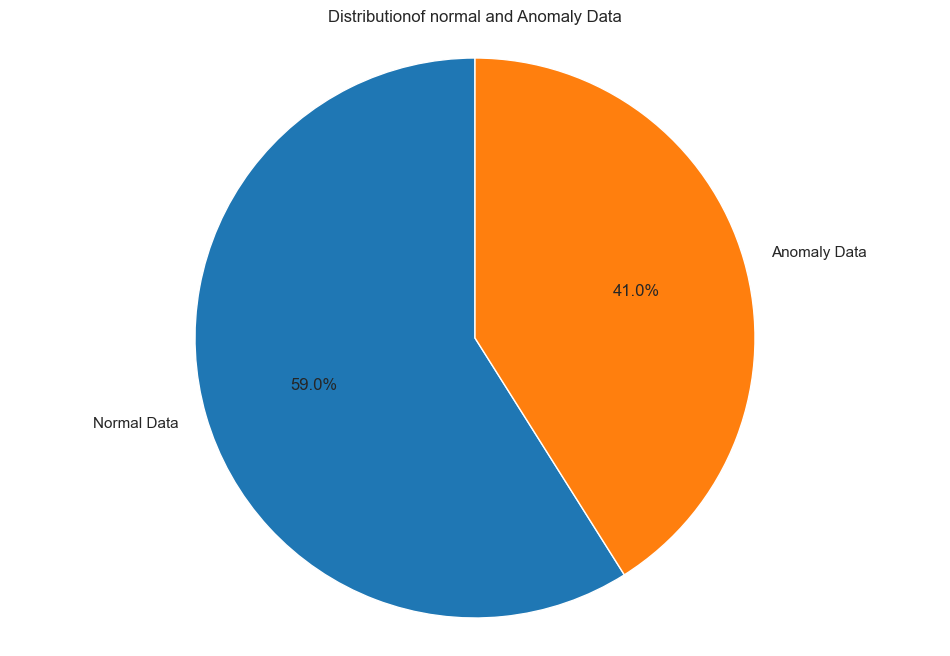

In [137]:
per_normal = normal/len(lb)*100
per_anomaly = anomaly/len(lb)*100

labels = ['Normal Data','Anomaly Data']
sizes = [per_normal,per_anomaly]
colors =  ['#1f77b4','#ff7f0e']
fig,ax = plt.subplots()
ax.pie(sizes,labels =  labels,colors = colors,autopct = '%1.1f%%',startangle = 90)
ax.axis('equal')
ax.set_title('Distributionof normal and Anomaly Data')
plt.show()

## Data Cleaning

In [138]:
df.dtypes

Class              object
Method             object
User-Agent         object
Pragma             object
Cache-Control      object
Accept             object
Accept-encoding    object
Accept-charset     object
language           object
host               object
cookie             object
content-type       object
connection         object
lenght             object
content            object
classification      int64
URL                object
dtype: object

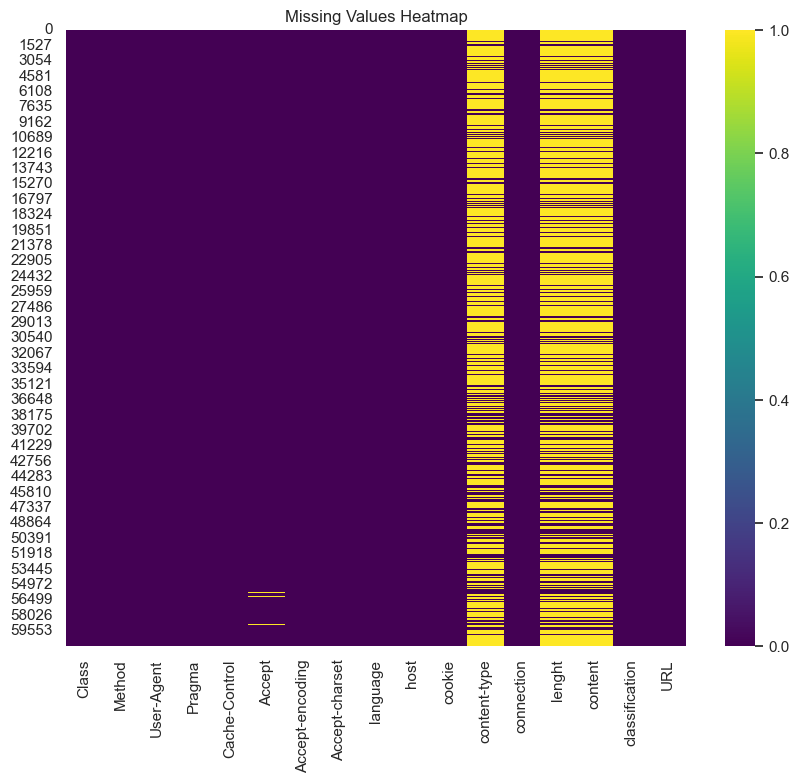

In [139]:
plt.figure(figsize=(10,8))
sns.heatmap(df.isnull(), cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

In [140]:
single_value_cols = [col for col in df.columns if df[col].nunique() == 1]
print("============================Columns That Contain only Single Values===================================")
print(single_value_cols)

============================Columns That Contain only Single Values===================================
['User-Agent', 'Pragma', 'Cache-Control', 'Accept', 'Accept-encoding', 'Accept-charset', 'language', 'content-type']


In [141]:
df = df.drop(single_value_cols,axis = 1)

In [142]:
df.isnull().sum()

Class                 0
Method                0
host                  0
cookie                0
connection            0
lenght            43088
content           43088
classification        0
URL                   0
dtype: int64

## Data encoding

In [143]:
enc  = OrdinalEncoder()

In [144]:
for column in df.columns:
  df[column] = enc.fit_transform(df[[column]])

In [145]:
df.head()

,Class,Method,host,cookie,connection,lenght,content,classification,URL
0,1.0,0.0,0.0,7623.0,1.0,NaN,NaN,0.0,800.0
1,1.0,0.0,0.0,31127.0,1.0,NaN,NaN,0.0,5503.0
2,1.0,1.0,0.0,35218.0,0.0,333.0,2190.0,0.0,3578.0
3,1.0,0.0,0.0,34368.0,1.0,NaN,NaN,0.0,6381.0
4,1.0,1.0,0.0,27185.0,0.0,324.0,3137.0,0.0,5840.0


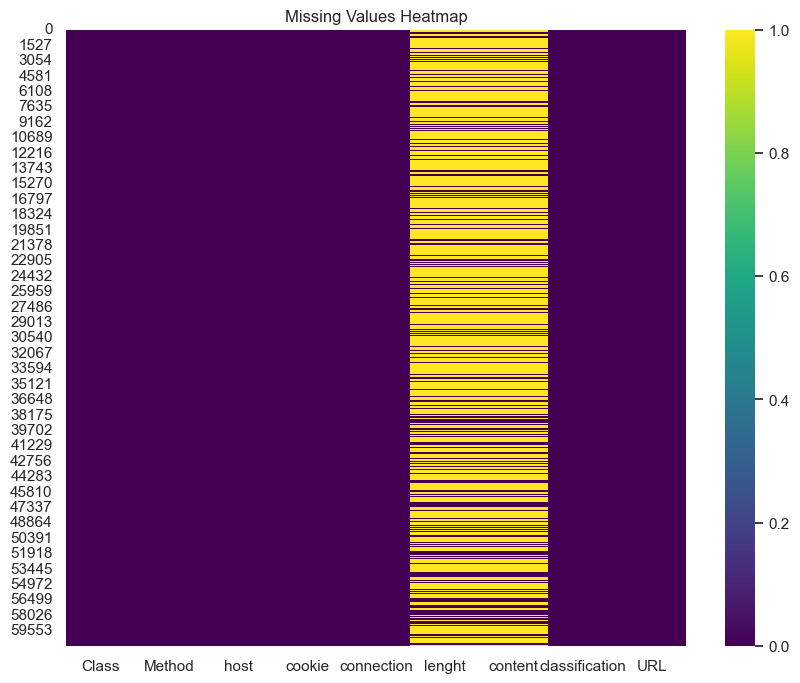

In [146]:
plt.figure(figsize=(10,8))
sns.heatmap(df.isnull(), cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

In [147]:
lenght_mean = df['lenght'].mean(skipna= True)
content_mean = df['content'].mean(skipna = True)
df['lenght'].fillna(lenght_mean,inplace = True)
df['content'].fillna(content_mean,inplace = True)

C:\Users\jnz\AppData\Local\Temp\ipykernel_44760\2787564913.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['lenght'].fillna(lenght_mean,inplace = True)
C:\Users\jnz\AppData\Local\Temp\ipykernel_44760\2787564913.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

In [148]:
df.isnull().sum()

Class             0
Method            0
host              0
cookie            0
connection        0
lenght            0
content           0
classification    0
URL               0
dtype: int64

## Data Normalization

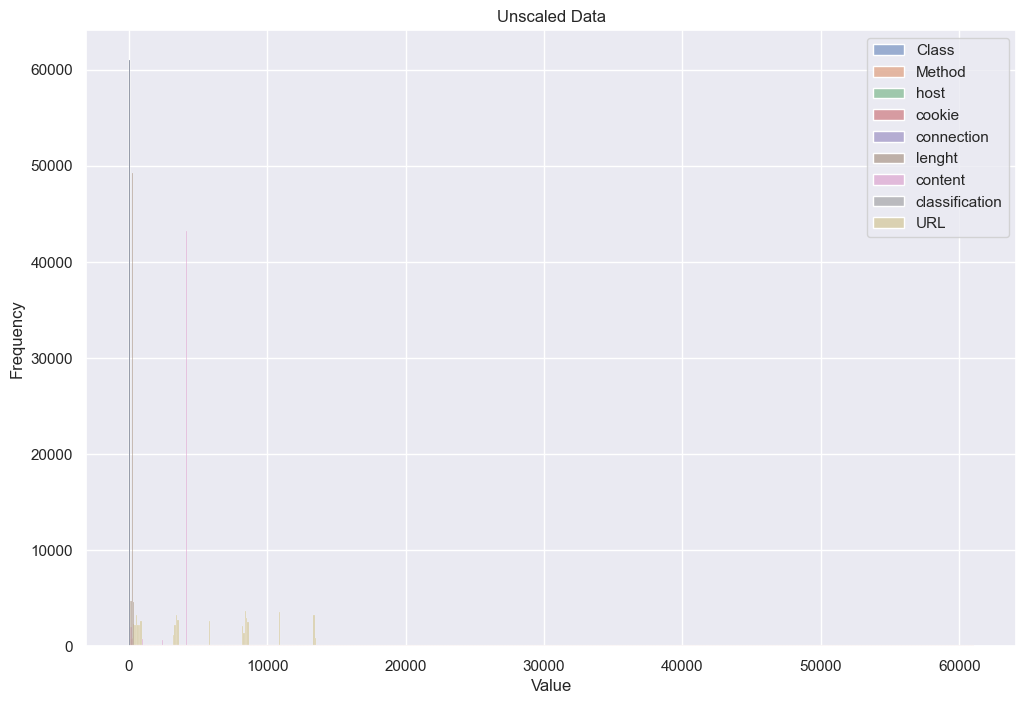

In [149]:
sns.set(rc = {'figure.figsize':(12,8)})

sns.histplot(df)
plt.title("Unscaled Data")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

In [150]:
for column in df.columns:
    df[column] = (df[column] - df[column].mean()) / df[column].std() # Z-score normalization

display(df)

,Class,Method,host,cookie,connection,lenght,content,classification,URL
0,0.834409,-0.636658,-0.080893,-1.299573,0.645917,0.000000,4.298734e-16,-0.834409,-1.117926
1,0.834409,-0.636658,-0.080893,0.033753,0.645917,0.000000,4.298734e-16,-0.834409,-0.020182
2,0.834409,1.479241,-0.080893,0.265826,-1.548161,2.095981,-9.662631e-01,-0.834409,-0.469503
3,0.834409,-0.636658,-0.080893,0.217607,0.645917,0.000000,4.298734e-16,-0.834409,0.184755
4,0.834409,1.479241,-0.080893,-0.189867,-1.548161,1.928922,-5.186627e-01,-0.834409,0.058478
...,...,...,...,...,...,...,...,...,...
61060,-1.198433,-0.636658,-0.080893,-0.394541,0.645917,0.000000,4.298734e-16,1.198433,-1.042300
61061,-1.198433,1.479241,-0.080893,-1.251185,-1.548161,-1.560762,1.533587e+00,1.198433,-1.098319
61062,-1.198433,-0.636658,-0.080893,0.001588,0.645917,0.000000,4.298734e-16,1.198433,-1.096685
61063,-1.198433,-0.636658,-0.080893,1.667509,0.645917,0.000000,4.298734e-16,1.198433,-1.159474


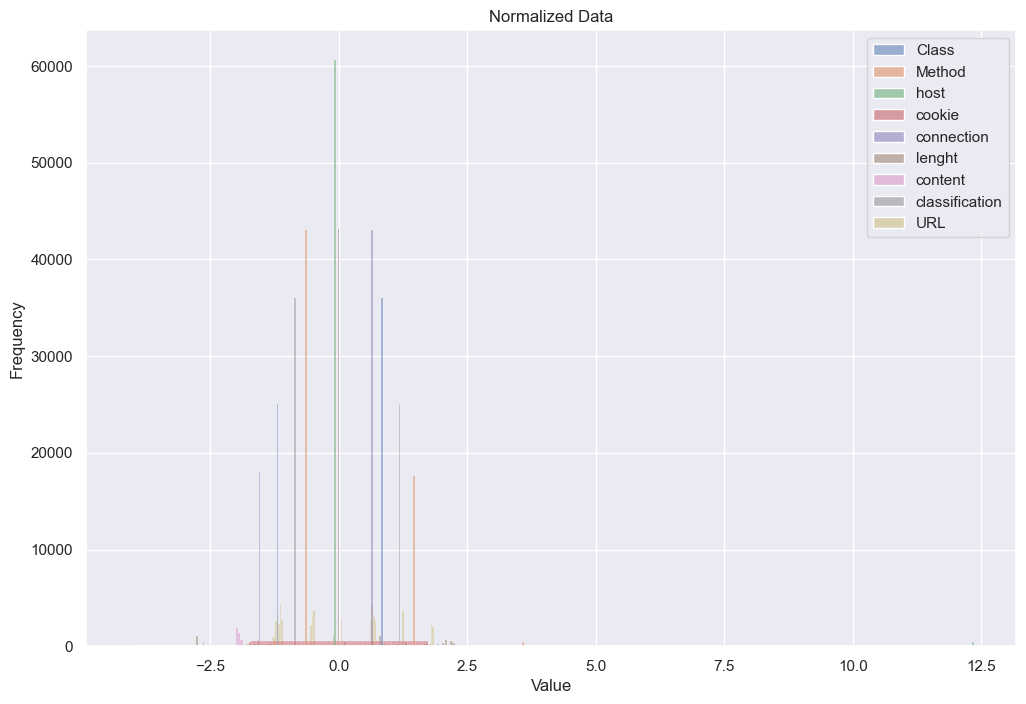

In [151]:
sns.set(rc = {'figure.figsize':(12,8)})

sns.histplot(df)
plt.title("Normalized Data")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

## Covariance Matrix

In [152]:
corr  = df.corr()
corr

,Class,Method,host,cookie,connection,lenght,content,classification,URL
Class,1.000000,-0.199492,-0.096947,-0.001923,1.897683e-01,-1.631635e-02,-4.893073e-02,-1.000000,-0.161084
Method,-0.199492,1.000000,0.290827,-0.000285,-9.856652e-01,4.077999e-04,-2.270858e-03,0.199492,0.252514
host,-0.096947,0.290827,1.000000,-0.005629,-1.252377e-01,2.398092e-03,-1.335392e-02,0.096947,0.031104
cookie,-0.001923,-0.000285,-0.005629,1.000000,-6.968841e-04,-4.199750e-03,-8.350891e-03,0.001923,0.002281
connection,0.189768,-0.985665,-0.125238,-0.000697,1.000000e+00,9.167190e-17,-1.297496e-16,-0.189768,-0.256360
lenght,-0.016316,0.000408,0.002398,-0.004200,9.167190e-17,1.000000e+00,-2.548609e-01,0.016316,-0.103724
content,-0.048931,-0.002271,-0.013354,-0.008351,-1.297496e-16,-2.548609e-01,1.000000e+00,0.048931,-0.119294
classification,-1.000000,0.199492,0.096947,0.001923,-1.897683e-01,1.631635e-02,4.893073e-02,1.000000,0.161084
URL,-0.161084,0.252514,0.031104,0.002281,-2.563598e-01,-1.037244e-01,-1.192940e-01,0.161084,1.000000


<Axes: title={'center': 'Correlation Matrix'}>

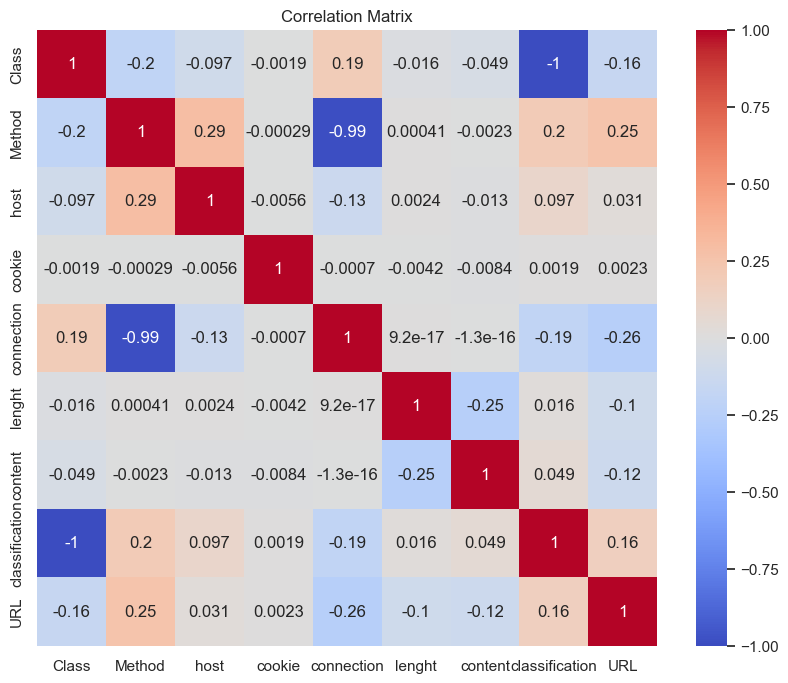

In [153]:
plt.figure(figsize = (10,8))
plt.title("Correlation Matrix")
sns.heatmap(corr,annot = True,cmap = 'coolwarm')

## RNN Model Training And Testings

In [154]:
encoder = LabelEncoder()

In [155]:
data = df
data = shuffle(data)

In [156]:
data.head()

,Class,Method,host,cookie,connection,lenght,content,classification,URL
24275,0.834409,-0.636658,-0.080893,-0.682433,0.645917,0.000000,4.298734e-16,-0.834409,0.749615
39731,-1.198433,1.479241,-0.080893,1.313472,-1.548161,0.648134,3.624594e+00,1.198433,0.702699
51058,-1.198433,1.479241,-0.080893,-1.113110,-1.548161,-1.783508,3.688402e+00,1.198433,1.250754
32105,0.834409,-0.636658,-0.080893,1.617702,0.645917,0.000000,4.298734e-16,-0.834409,-0.486309
43484,-1.198433,3.595140,12.361781,0.715676,-1.548161,-2.767302,-1.987662e+00,1.198433,1.812580


In [157]:
data['Class'] = encoder.fit_transform(data['Class'])

In [158]:
X2 = data.drop('Class', axis=1)
y2 = data['Class']

In [159]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2)
X_train22, X_test22, y_train22, y_test22 = train_test_split(X2, y2, test_size=0.3)

In [160]:
model_rnn = Sequential()
model_rnn.add(SimpleRNN(units=32, activation='relu', input_shape=(X_train2.shape[1], 1)))
model_rnn.add(Dropout(0.2))
model_rnn.add(Dense(64, activation='relu'))
model_rnn.add(Dropout(0.2))
model_rnn.add(Dense(units=1, activation='sigmoid'))

c:\Users\jnz\Documents\webattack-payload-detector\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [161]:
print("---------------------------------------------Training--------------------------------------------------------")
#adam =  Adam(lr = 0.1,beta_1 = 0.7,beta_2  = 0.77)
model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_rnn.fit(X_train2.values.reshape((X_train2.shape[0], X_train2.shape[1], 1)), y_train2, batch_size=32)

loss_score, accuracy = model_rnn.evaluate(X_test22.values.reshape((X_test22.shape[0], X_test22.shape[1], 1)), y_test22)
print("Train Loss:",loss_score)
print(f"Train Accuracy:", accuracy)
# loss.append(loss_score)
# acc.append(accuracy)
#print("---------------------------------------------Testing--------------------------------------------------------")
test_predictions = np.round(model_rnn.predict(X_test22)).flatten()
test_accuracy = accuracy_score(y_test22, test_predictions)
test_confusion_matrix = confusion_matrix(y_test22, test_predictions)


print(test_accuracy)

---------------------------------------------Training--------------------------------------------------------
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9972 - loss: 0.0141
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9972 - loss: 0.0141
573/573 ━━━━━━━━━━━━━━━━━━━━ 1s 986us/step - accuracy: 1.0000 - loss: 1.7200e-06
573/573 ━━━━━━━━━━━━━━━━━━━━ 1s 986us/step - accuracy: 1.0000 - loss: 1.7200e-06
Train Loss: 1.7199539570356137e-06
Train Accuracy: 1.0
Train Loss: 1.7199539570356137e-06
Train Accuracy: 1.0
573/573 ━━━━━━━━━━━━━━━━━━━━ 1s 808us/step
573/573 ━━━━━━━━━━━━━━━━━━━━ 1s 808us/step
1.0
1.0


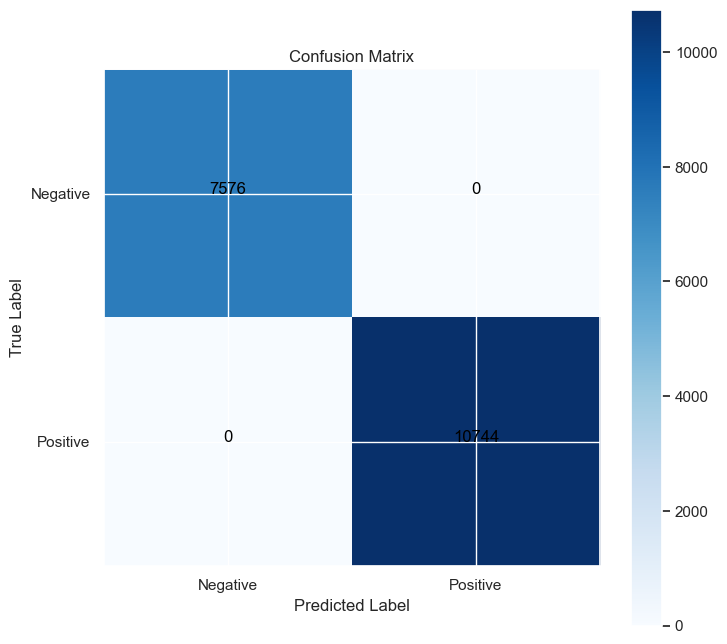

In [162]:
plt.figure(figsize = (8,8))
plt.imshow(test_confusion_matrix, cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks([0, 1], ["Negative", "Positive"])
plt.yticks([0, 1], ["Negative", "Positive"])

thresh = test_confusion_matrix.max() / 2.
for i in range(test_confusion_matrix.shape[0]):
    for j in range(test_confusion_matrix.shape[1]):
        plt.text(j, i, test_confusion_matrix[i, j],
                horizontalalignment="center",
                 color="Black" if test_confusion_matrix[i, j] > thresh else "black")

plt.colorbar()

plt.show()

## Export Model 

In [163]:
model_rnn.save("models/simple_rnn_final.keras")

In [164]:
model_rnn = tf.keras.models.load_model("models/simple_rnn_final.keras")

### Retrain Model with Checkpointing and Early Stopping

This section retrains the RNN model using callbacks to save the best performing model and prevent overfitting through early stopping.

In [165]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

ckpt = ModelCheckpoint(
    "models/simple_rnn_best.keras", monitor="val_accuracy",
    save_best_only=True, mode="max", verbose=1
)
es = EarlyStopping(patience=3, restore_best_weights=True, monitor="val_accuracy", mode="max")

model_rnn.fit(
    X_train2.values.reshape((X_train2.shape[0], X_train2.shape[1], 1)),
    y_train2,
    validation_data=(
        X_test2.values.reshape((X_test2.shape[0], X_test2.shape[1], 1)),
        y_test2
    ),
    batch_size=32, epochs=30,
    callbacks=[ckpt, es], verbose=1
)


Epoch 1/30
1497/1527 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9996 - loss: 0.0010
Epoch 1: val_accuracy improved from None to 1.00000, saving model to models/simple_rnn_best.keras

Epoch 1: val_accuracy improved from None to 1.00000, saving model to models/simple_rnn_best.keras
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9999 - loss: 3.6480e-04 - val_accuracy: 1.0000 - val_loss: 7.8836e-08
Epoch 2/30
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9999 - loss: 3.6480e-04 - val_accuracy: 1.0000 - val_loss: 7.8836e-08
Epoch 2/30
1507/1527 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 4.6953e-05
Epoch 2: val_accuracy did not improve from 1.00000
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 1.0000 - loss: 5.6127e-05 - val_accuracy: 1.0000 - val_loss: 2.1512e-08
Epoch 3/30

Epoch 2: val_accuracy did not improve from 1.00000
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 1.0000 - loss: 5.6127e-05 - val_accuracy: 1.0000 - val_loss: 2

In [166]:
model_rnn.fit(
    X_train2.values.reshape((X_train2.shape[0], X_train2.shape[1], 1)),
    y_train2,
    validation_data=(
        X_test2.values.reshape((X_test2.shape[0], X_test2.shape[1], 1)),
        y_test2
    ),
    batch_size=32, epochs=30,
    callbacks=[ckpt, es], verbose=1
)

Epoch 1/30
1519/1527 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 3.6515e-05
Epoch 1: val_accuracy did not improve from 1.00000
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 1.0000 - loss: 2.1116e-05 - val_accuracy: 1.0000 - val_loss: 1.1989e-08
Epoch 2/30

Epoch 1: val_accuracy did not improve from 1.00000
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 1.0000 - loss: 2.1116e-05 - val_accuracy: 1.0000 - val_loss: 1.1989e-08
Epoch 2/30
1507/1527 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9999 - loss: 1.5045e-04
Epoch 2: val_accuracy did not improve from 1.00000
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9999 - loss: 2.5146e-04 - val_accuracy: 1.0000 - val_loss: 2.3025e-07
Epoch 3/30

Epoch 2: val_accuracy did not improve from 1.00000
1527/1527 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9999 - loss: 2.5146e-04 - val_accuracy: 1.0000 - val_loss: 2.3025e-07
Epoch 3/30
1501/1527 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss:

### Convert Keras Model to PyTorch and Export to ONNX

This section creates an equivalent PyTorch RNN model, transfers the trained weights from the Keras model, and exports it to ONNX format for cross-platform deployment.

In [167]:

# Define equivalent PyTorch model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size=32, dense_size=64):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(hidden_size, dense_size)
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(dense_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # x shape: (batch, seq_len, features)
        out, _ = self.rnn(x)
        out = out[:, -1, :]  # Take last timestep output
        out = self.dropout1(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout2(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

# Create PyTorch model with same architecture
input_features = X_train2.shape[1]
pytorch_model = SimpleRNN(input_size=1, hidden_size=32, dense_size=64)

# Copy weights from Keras model to PyTorch model
keras_weights = model_rnn.get_weights()

# Map Keras RNN weights to PyTorch
# Keras SimpleRNN: kernel (input), recurrent_kernel, bias
# PyTorch RNN: weight_ih_l0 (input), weight_hh_l0 (hidden), bias_ih_l0, bias_hh_l0
with torch.no_grad():
    # RNN weights
    pytorch_model.rnn.weight_ih_l0.copy_(torch.tensor(keras_weights[0].T))  # Input weights
    pytorch_model.rnn.weight_hh_l0.copy_(torch.tensor(keras_weights[1].T))  # Recurrent weights
    pytorch_model.rnn.bias_ih_l0.copy_(torch.tensor(keras_weights[2]))       # Bias
    pytorch_model.rnn.bias_hh_l0.zero_()  # PyTorch has separate bias, Keras combines them
    
    # Dense layer 1 (64 units)
    pytorch_model.fc1.weight.copy_(torch.tensor(keras_weights[3].T))
    pytorch_model.fc1.bias.copy_(torch.tensor(keras_weights[4]))
    
    # Dense layer 2 (output)
    pytorch_model.fc2.weight.copy_(torch.tensor(keras_weights[5].T))
    pytorch_model.fc2.bias.copy_(torch.tensor(keras_weights[6]))

pytorch_model.eval()
print("PyTorch model created and weights transferred!")

PyTorch model created and weights transferred!


In [168]:
# Export PyTorch model to ONNX using legacy exporter (more stable for RNNs)
dummy_input = torch.randn(1, input_features, 1)  # (batch, seq_len, input_size)

torch.onnx.export(
    pytorch_model,
    dummy_input,
    "models/simple_rnn.onnx",
    export_params=True,
    opset_version=13,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    },
    dynamo=False  
)

print("Model exported to models/simple_rnn.onnx")

# Verify the ONNX model
import onnx
onnx_model = onnx.load("models/simple_rnn.onnx")
onnx.checker.check_model(onnx_model)
print("ONNX model is valid!")

Model exported to models/simple_rnn.onnx
ONNX model is valid!


C:\Users\jnz\AppData\Local\Temp\ipykernel_44760\3034394171.py:4: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(
c:\Users\jnz\Documents\webattack-payload-detector\.venv\Lib\site-packages\torch\onnx\_internal\torchscript_exporter\symbolic_opset9.py:4247: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with RNN_TANH can cause an error when running the ONNX model with a different batch size. Make sure 